In [110]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import awkward
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import uproot_methods
import glob
from tqdm.auto import tqdm

import sys
sys.path.insert(0,"matplottery/")
from matplottery import Hist1D, plot_stack
from matplottery.utils import clopper_pearson_error

In [2]:
f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau50mm.root")
# f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau5mm.root")
t = f["Events"]

In [3]:
tlead = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("LeadingPair_*",outputtype=dict,namedecode="ascii").items()})
tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii").items()})
thlt = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("HLT_*",outputtype=dict,namedecode="ascii").items()})
tl1 = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("L1_*",outputtype=dict,namedecode="ascii").items()})

tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
tdv["rho"] = np.hypot(tdv.x,tdv.y)
tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

tevt = awkward.Table()
tevt["skim"] = (tdv.x.counts>=1) & (tmu.pt.counts>=2)
tevt["hlt"] = thlt["DoubleMu3_noVtx"]
tevt["l1"] = (tl1["DoubleMu4p5_SQ_OS_dR_Max1p2"] | tl1["DoubleMu_15_5_SQ"] | tl1["DoubleMu_15_7"])
tevt["goodgen"] = ((
        (tgen.pt>4.)
        & (np.abs(tgen.eta)<2.4)
        & (tgen.rho < 11.)
    ).sum() >= 2)

In [4]:
(tevt["goodgen"] & tevt["l1"] & tevt["skim"]).mean()

0.179340206185567

In [5]:
goodgen = ((
    (tgen.pt>4.)
    & (np.abs(tgen.eta)<2.4)
    & (tgen.rho < 11.)
#     (np.abs(tgen.eta)<2.1)
#     (tgen.pt>5.)
#     (tgen.rho < 11.)
).sum() >= 2)
goodgen.mean()

0.38129484536082475

In [6]:
pd.Series(tgen.pt.counts).value_counts()/len(tgen)

2    0.982115
4    0.017885
dtype: float64

In [7]:
df = pd.DataFrame(thlt._contents)
df.head()

,CaloJet40_CaloBTagScouting,CaloScoutingHT250,CaloBTagScoutingHT250,CaloBTagScoutingL1HTT,ZeroBias_CaloScouting_PFScouting,DoubleMu1_noVtx,DoubleMu3_noVtx,DoubleMu3_noVtx_Monitoring
0,False,False,False,False,True,True,True,False
1,True,False,False,False,True,False,False,False
2,False,False,False,False,True,True,True,False
3,True,False,False,True,True,False,False,False
4,True,False,False,False,True,False,False,False


In [8]:
df[goodgen].mean()

CaloJet40_CaloBTagScouting          0.418541
CaloScoutingHT250                   0.023977
CaloBTagScoutingHT250               0.023544
CaloBTagScoutingL1HTT               0.061256
ZeroBias_CaloScouting_PFScouting    1.000000
DoubleMu1_noVtx                     0.533516
DoubleMu3_noVtx                     0.523880
DoubleMu3_noVtx_Monitoring          0.023977
dtype: float64

In [9]:
df = pd.DataFrame(tl1._contents)
df = df[df.columns[~df.columns.str.contains("_prescale")]]
# df = df[df.columns[df.columns.str.contains("_prescale")]]
df

,DoubleMu0,DoubleMu0_Mass_Min1,DoubleMu0_OQ,DoubleMu0_SQ,DoubleMu0_SQ_OS,DoubleMu0er1p4_SQ_OS_dR_Max1p4,DoubleMu0er1p5_SQ,DoubleMu0er1p5_SQ_OS,DoubleMu0er1p5_SQ_OS_dR_Max1p4,DoubleMu0er1p5_SQ_dR_Max1p4,...,TripleMu_5SQ_3SQ_0OQ_DoubleMu_5_3_SQ_OS_Mass_Max9,TripleMu_5SQ_3SQ_0_DoubleMu_5_3_SQ_OS_Mass_Max9,TripleMu_5_3_3,TripleMu_5_3_3_SQ,TripleMu_5_3p5_2p5,TripleMu_5_3p5_2p5_DoubleMu_5_2p5_OS_Mass_5to17,TripleMu_5_3p5_2p5_OQ_DoubleMu_5_2p5_OQ_OS_Mass_5to17,TripleMu_5_4_2p5_DoubleMu_5_2p5_OS_Mass_5to17,TripleMu_5_5_3,ZeroBias
0,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,True,True,True,True,True,False,True,True,False,False,...,False,False,True,True,True,False,False,False,True,True
3,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,True,True,True,True,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242495,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
242496,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True
242497,True,True,True,True,True,True,True,True,True,True,...,False,False,True,False,True,True,True,True,True,True
242498,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,True


In [10]:
toconsider = [
    "DoubleMu_15_5_SQ",
    "DoubleMu9_SQ",
    "DoubleMu_15_7",
    "DoubleMu10_SQ",
    "DoubleMu4p5_SQ_OS_dR_Max1p2",
    "DoubleMu18er2p1",
    "DoubleMu0er1p5_SQ_OS_dR_Max1p4",
    "DoubleMu0er1p4_SQ_OS_dR_Max1p4",
    "DoubleMu_15_7_SQ",
]

goodeta = np.ones(len(df))>0
# goodeta = (np.abs(tgen.eta)<1.5).sum()>=2

s = df.loc[goodgen & goodeta,df.columns.isin(toconsider)].mean()
pd.DataFrame({"":s.index,"eff":s.values}).sort_values("eff")
# .set_index("L1")
# d.columns
# df[goodgen].mean()

,,eff
3,DoubleMu18er2p1,0.343961
0,DoubleMu0er1p4_SQ_OS_dR_Max1p4,0.465197
1,DoubleMu0er1p5_SQ_OS_dR_Max1p4,0.500022
4,DoubleMu4p5_SQ_OS_dR_Max1p2,0.625681
2,DoubleMu10_SQ,0.648479
5,DoubleMu9_SQ,0.683174
8,DoubleMu_15_7_SQ,0.763292
7,DoubleMu_15_7,0.783440
6,DoubleMu_15_5_SQ,0.842858


In [11]:
allnames = [
    "DoubleMu_15_5_SQ",
#     "DoubleMu9_SQ",
    "DoubleMu_15_7",
#     "DoubleMu10_SQ",
    "DoubleMu4p5_SQ_OS_dR_Max1p2",
#     "DoubleMu0er1p5_SQ_OS_dR_Max1p4",
#     "DoubleMu0er1p4_SQ_OS_dR_Max1p4",
    "DoubleMu_15_7_SQ",
]

allor = df[allnames].sum(axis=1)>0
allor[goodgen].mean()

0.867083405433466

In [12]:
def calc_eff(names):
    names = list(names)
    allor = df[names].sum(axis=1)>0
    return allor[goodgen].mean()

import itertools
combs = itertools.combinations(allnames,3)
data = []
for comb in combs:
    data.append([list(comb),calc_eff(comb)])
# pd.DataFrame(data,columns=["comb","eff"]).sort_values("eff",ascending=False).comb.values
d = pd.DataFrame(data,columns=["comb","eff"]).sort_values("eff",ascending=False)
d.comb = d.comb.apply(lambda y:sorted([x.replace("DoubleMu","") for x in y]))
d
# na

,comb,eff
0,"[4p5_SQ_OS_dR_Max1p2, _15_5_SQ, _15_7]",0.867083
1,"[_15_5_SQ, _15_7, _15_7_SQ]",0.862693
2,"[4p5_SQ_OS_dR_Max1p2, _15_5_SQ, _15_7_SQ]",0.847259
3,"[4p5_SQ_OS_dR_Max1p2, _15_7, _15_7_SQ]",0.808390


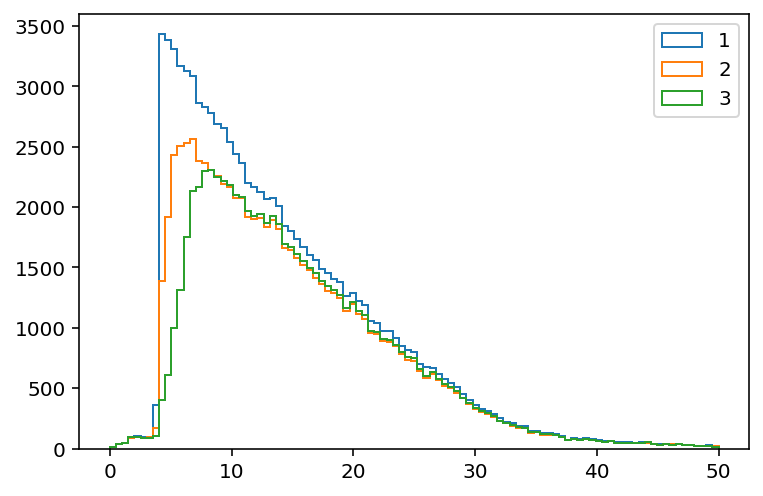

In [13]:
# v = tgen.p4[:,0].delta_r(tgen.p4[:,1])[goodgen]
# v = np.maximum(tgen.pt[:,0][goodgen],tgen.pt[:,1][goodgen])
v = np.minimum(tgen.pt[:,0][goodgen],tgen.pt[:,1][goodgen])
fig,ax = plt.subplots()
# ax.hist(v,bins="auto");
# bins = np.linspace(0,4,100)
bins = np.linspace(0,50,100)

ax.hist(v,bins=bins,histtype="step",label="1");

# sel = tl1["DoubleMu4_SQ_OS_dR_Max1p2"][goodgen]
sel = tl1["DoubleMu_15_5_SQ"][goodgen]
ax.hist(v[sel],bins=bins,histtype="step",label="2");

# sel = tl1["DoubleMu4p5_SQ_OS_dR_Max1p2"][goodgen]
sel = tl1["DoubleMu_15_7"][goodgen]
ax.hist(v[sel],bins=bins,histtype="step",label="3");
ax.legend()

In [136]:
%%time
f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/ScoutingCaloMuon/2018C/unblind1fb/output_0.root")
t = f["Events"]

# tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
# tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
# thlt = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("HLT_*",outputtype=dict,namedecode="ascii").items()})
tl1 = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("L1_*",outputtype=dict,namedecode="ascii").items()})

# tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
# tdv["rho"] = np.hypot(tdv.x,tdv.y)
# tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

CPU times: user 1.82 s, sys: 44 ms, total: 1.86 s
Wall time: 4.85 s


In [188]:
vprescaleon = []
vtrigon = []

In [189]:
fnames = glob.glob("/hadoop/cms/store/user/namin/DisplacedMuons/ScoutingCaloMuon/2018C/unblind1fb/output_*.root")
for fname in tqdm(fnames):
    f = uproot.open(fname)
    t = f["Events"]
    df = pd.DataFrame(t.arrays(t.keys(filtername=lambda x:x.decode().startswith("L1_DoubleMu")),namedecode="ascii"))
    prescaleon = (df.filter(regex="_prescale",axis=1) == 1).sum()
    trigon = (df[df.columns[~df.columns.str.contains("_prescale")]] == 1).sum()

    vprescaleon.append(prescaleon)
    vtrigon.append(trigon)

In [16]:

from dask.distributed import Client
scheduler_url = "uaf-10.t2.ucsd.edu:50123"
c = Client(scheduler_url)
c

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 37 Cores: 37 Memory: 185.00 GB


In [17]:
%%html
<iframe src="http://localhost:8787/status" width="100%" height="500px"></iframe>

In [18]:
def getinfo(fname):
    f = uproot.open(fname)
    t = f["Events"]
#     return len(t)
    df = pd.DataFrame(t.arrays(t.keys(filtername=lambda x:x.decode().startswith("L1_DoubleMu")),namedecode="ascii"))
    prescaleon = (df.filter(regex="_prescale",axis=1) == 1).sum()
    trigon = (df[df.columns[~df.columns.str.contains("_prescale")]] == 1).sum()
    prescaleon.index = prescaleon.index.str.replace("_prescale","")
    return prescaleon, trigon
    
fnames = glob.glob("/hadoop/cms/store/user/namin/DisplacedMuons/ScoutingCaloMuon/2018C/unblind1fb/output_*.root")
nevents = sum(c.gather(c.map(lambda x: len(uproot.open(x)["Events"]),fnames)))
results = c.gather(c.map(getinfo,fnames))

In [19]:
df = pd.DataFrame()
df["prescale1"] = sum(list(zip(*results))[0])/nevents
df["fired"] = sum(list(zip(*results))[1])/nevents
df = df.round(2).sort_values("prescale1")
df.columns = ["prescale==1 fraction", "fired fraction"]

In [20]:
df

,prescale==1 fraction,fired fraction
L1_DoubleMu0,0.00,0.00
L1_DoubleMu4p5_SQ_OS,0.00,0.00
L1_DoubleMu4_SQ_OS,0.00,0.00
L1_DoubleMu_12_5,0.00,0.00
L1_DoubleMu_15_7_Mass_Min1,0.00,0.00
L1_DoubleMu0er2p0_SQ_dR_Max1p4,0.00,0.00
L1_DoubleMu0er2p0_SQ_OS_dR_Max1p4,0.00,0.00
L1_DoubleMu0er1p5_SQ_dR_Max1p4,0.00,0.00
L1_DoubleMu0er1p5_SQ,0.00,0.00
L1_DoubleMu0_SQ_OS,0.00,0.00


In [21]:
results[0][0].index.str.replace("_prescale","")

Index(['L1_DoubleMu0', 'L1_DoubleMu0_Mass_Min1', 'L1_DoubleMu0_OQ',
       'L1_DoubleMu0_SQ', 'L1_DoubleMu0_SQ_OS',
       'L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4', 'L1_DoubleMu0er1p5_SQ',
       'L1_DoubleMu0er1p5_SQ_OS', 'L1_DoubleMu0er1p5_SQ_OS_dR_Max1p4',
       'L1_DoubleMu0er1p5_SQ_dR_Max1p4', 'L1_DoubleMu0er2p0_SQ_OS_dR_Max1p4',
       'L1_DoubleMu0er2p0_SQ_dR_Max1p4', 'L1_DoubleMu10_SQ',
       'L1_DoubleMu18er2p1', 'L1_DoubleMu4_SQ_OS',
       'L1_DoubleMu4_SQ_OS_dR_Max1p2', 'L1_DoubleMu4p5_SQ_OS',
       'L1_DoubleMu4p5_SQ_OS_dR_Max1p2', 'L1_DoubleMu4p5er2p0_SQ_OS',
       'L1_DoubleMu4p5er2p0_SQ_OS_Mass7to18', 'L1_DoubleMu9_SQ',
       'L1_DoubleMu_12_5', 'L1_DoubleMu_15_5_SQ', 'L1_DoubleMu_15_7',
       'L1_DoubleMu_15_7_Mass_Min1', 'L1_DoubleMu_15_7_SQ'],
      dtype='object')

## Full 2018 with dask

In [22]:
from dask.distributed import Client, progress
from dask import delayed
scheduler_url = "uaf-10.t2.ucsd.edu:50123"
c = Client(scheduler_url)
# c.restart()
c

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 50 Cores: 50 Memory: 250.00 GB


In [23]:
def get_chunking_dask(filelist, chunksize, client=None, treename="Events"):
    import uproot
    chunks, chunksize, nevents = [], int(chunksize), 0
    def f(x):
        try: return x, uproot.numentries(x,treename)
        except: return x, 0
            
    info = client.gather(client.map(f,filelist))
    for fn, nentries in info:
        if nentries <= 0: continue
        nevents += nentries
        for index in range(nentries // chunksize + 1):
            chunks.append((fn, chunksize*index, min(chunksize*(index+1), nentries)))
    return chunks, nevents

In [31]:
fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/ScoutingCaloMuon/crab_skim_2018*_v4/*/0000/output_*.root"))
print(len(fnames))

# shuffle, but same way
a = np.array(fnames)
np.random.seed(42)
np.random.shuffle(a)
fnames = a.tolist()

fnames = fnames[:5000]
# chunks, total_nevents = get_chunking(tuple(fnames),int(1.5e6))
chunks, total_nevents = get_chunking_dask(tuple(fnames),int(1.0e6), client=c)
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

1189
4500 chunks of 1189 files, with a total of 3.9159e+09 events


In [25]:
%%time
def get_info(chunk):
    fname,entrystart,entrystop = chunk
    extra = dict(namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    t = uproot.open(fname)["Events"]
    results,prescales = t.arrays(
        ["bools_triggerMaker_l1result_SLIM.obj","ints_triggerMaker_l1prescale_SLIM.obj"],
        outputtype=tuple,
        **extra
    )
    nevents = len(results)
    fired = results.content.reshape(-1,results[0].shape[0]).sum(axis=0)
    unprescaled = (prescales.content.reshape(-1,prescales[0].shape[0])==1).sum(axis=0)
    return nevents, fired, unprescaled

get_info((chunks[0][0],chunks[0][1],500000))

CPU times: user 1.27 s, sys: 1.38 s, total: 2.65 s
Wall time: 3.71 s


(500000, array([     0,      0,      0,   2503,      0, 179880,      0,      0,
        215598,      0,      0,      0,  49729,  10123,      0,      0,
          6246, 302213,      0,  97952,  63075,      0,  89295,  71803,
             0,  69351,      0,      0,      0,      0,      0,      0,
             0,  73146,   3162,  79508,  67576,  86509,  72466,   1717,
         45770,      0,  43887,  61081,     28]), array([     0,      0,      0,      0,      0, 500000,      0,      0,
        500000,      0,      0,      0, 500000, 500000,      0,      0,
             0, 500000,      0, 500000, 500000,      0, 500000, 500000,
             0, 500000,      0,      0,      0,      0,      0,      0,
             0, 500000,      0, 500000, 500000, 500000, 500000,      0,
        500000,      0, 500000, 500000,      0]))

In [26]:
%%time
names = list(map(lambda x:x.decode(),uproot.open(chunks[0][0])["Events"]["Strings_triggerMaker_l1name_SLIM.obj"].array(entrystop=1)[0]))
names

CPU times: user 161 ms, sys: 4 ms, total: 165 ms
Wall time: 239 ms


['L1_DoubleMu0',
 'L1_DoubleMu0_Mass_Min1',
 'L1_DoubleMu0_OQ',
 'L1_DoubleMu0_SQ',
 'L1_DoubleMu0_SQ_OS',
 'L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4',
 'L1_DoubleMu0er1p5_SQ',
 'L1_DoubleMu0er1p5_SQ_OS',
 'L1_DoubleMu0er1p5_SQ_OS_dR_Max1p4',
 'L1_DoubleMu0er1p5_SQ_dR_Max1p4',
 'L1_DoubleMu0er2p0_SQ_OS_dR_Max1p4',
 'L1_DoubleMu0er2p0_SQ_dR_Max1p4',
 'L1_DoubleMu10_SQ',
 'L1_DoubleMu18er2p1',
 'L1_DoubleMu4_SQ_OS',
 'L1_DoubleMu4_SQ_OS_dR_Max1p2',
 'L1_DoubleMu4p5_SQ_OS',
 'L1_DoubleMu4p5_SQ_OS_dR_Max1p2',
 'L1_DoubleMu4p5er2p0_SQ_OS',
 'L1_DoubleMu4p5er2p0_SQ_OS_Mass7to18',
 'L1_DoubleMu9_SQ',
 'L1_DoubleMu_12_5',
 'L1_DoubleMu_15_5_SQ',
 'L1_DoubleMu_15_7',
 'L1_DoubleMu_15_7_Mass_Min1',
 'L1_DoubleMu_15_7_SQ',
 'L1_QuadMu0',
 'L1_QuadMu0_OQ',
 'L1_QuadMu0_SQ',
 'L1_TripleMu0',
 'L1_TripleMu0_OQ',
 'L1_TripleMu0_SQ',
 'L1_TripleMu3',
 'L1_TripleMu3_SQ',
 'L1_TripleMu_5SQ_3SQ_0OQ',
 'L1_TripleMu_5SQ_3SQ_0OQ_DoubleMu_5_3_SQ_OS_Mass_Max9',
 'L1_TripleMu_5SQ_3SQ_0_DoubleMu_5_3_SQ_OS_Mass_Max9',


In [27]:
futures = c.map(get_info,chunks)

progress(futures)

VBox()

In [28]:
results = c.gather(futures)

nevents = 0
fired = np.zeros(len(names))
unprescaled = np.zeros(len(names))
for r in results:
    if r is not None:
        nevents += r[0]
        fired += r[1]
        unprescaled += r[2]
# xy = sum(r[0] for r in results)
# rhoz = sum(r[1] for r in results)

In [29]:
nevents/1e9

3.91585417

In [30]:
df = pd.DataFrame([names,fired,unprescaled]).T
df.columns = ["name","fired","unprescaled"]
df = df[(~df["name"].str.contains("Triple")) & (~df["name"].str.contains("Quad"))]
df = df.set_index("name")
df = df.sort_values(["unprescaled","fired"])
df /= nevents
df

,fired,unprescaled
name,,
L1_DoubleMu0,0,0
L1_DoubleMu0_Mass_Min1,0,0
L1_DoubleMu0_OQ,0,0
L1_DoubleMu0_SQ_OS,0,0
L1_DoubleMu0er1p5_SQ,0,0
L1_DoubleMu0er2p0_SQ_OS_dR_Max1p4,0,0
L1_DoubleMu0er2p0_SQ_dR_Max1p4,0,0
L1_DoubleMu_12_5,0,0
L1_DoubleMu_15_7_Mass_Min1,0,0
